#  Learning Various Deep Learning Techniques on MNIST

Starting from pure PyTorch.

# Getting the Data Ready

In [0]:
from fastai.vision import *
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback, EarlyStoppingCallback

In [0]:
mnist = untar_data(URLs.MNIST)

In [3]:
mnist.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
# data = (ImageList.from_folder(mnist)#,convert_mode='L')
#     .split_by_folder()
#     .label_from_folder()
#     .add_test_folder(mnist/'test')
#     .databunch(bs=128)
#     .normalize(imagenet_stats))

In [4]:
#torch.cuda.init()
torch.cuda.max_memory_allocated(0)

0

In [0]:
tfms = get_transforms(do_flip=False)
data = (ImageList.from_folder(mnist/'training')#,convert_mode='L')
        .split_by_rand_pct() # split_by_folder()          
        .label_from_folder()
        .add_test_folder(mnist/'testing')
        .transform(tfms, size=28)
        .databunch(bs=128)
        .normalize(imagenet_stats))

In [6]:
data

ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png/training;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,0,8,5,6
Path: /root/.fastai/data/mnist_png/training;

Test: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: /root/.fastai/data/mnist_png/training

In [0]:
#data.test_ds.path = mnist/'testing'

In [0]:
torch.cuda.init()

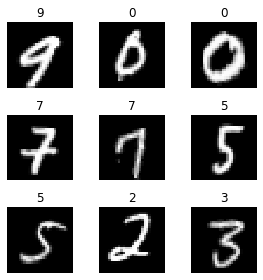

In [8]:
data.show_batch(rows=3,figsize=(4,4))

# 1-layer Neural net from scratch (no torch.nn)

## Model

In [0]:
inp = data.train_ds.x[0].px.squeeze().reshape(-1).shape[0]
c = data.train_ds.c
inp,c

In [0]:
data.train_ds.x[0].px.squeeze().reshape(-1).shape

In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [0]:
def model(x):
    return log_softmax(x @ w + b)

In [0]:
def accuracy(pred,y):
    return (pred.argmax(dim=1) == y).float().mean()

In [0]:
def error(pred,y):
    return 1-accuracy(pred,y)

In [0]:
def nll(pred,yb):
    return -pred[range(yb.shape[0]), yb].mean()
loss_func = nll

In [0]:
def stats(w):
    #with torch.no_grad(): 
    return w.mean().item(),w.std().item()
    return 'w.mean='+str(w.mean().item())+', w.std='+str(w.std().item())

In [0]:
def stats_str(w):
    m,s = stats(w)
    return f'{m}, {s}'

## Training

In [0]:
import pandas as pd
df = pd.DataFrame()

In [0]:
w = torch.randn((inp,c)) * math.sqrt(2/inp) #/ math.sqrt(784) # Xavier init
w.requires_grad_()
b = torch.zeros(c, requires_grad=True)

In [0]:
xb,yb = next(iter(data.train_dl))

In [0]:
xb = xb.reshape(-1,784)
xb.shape

In [0]:
epochs,lr=2,0.4
res = []
for epoch in range(epochs):
  #  print(f'---- Epoch: {epoch} ----')
    for xb,yb in data.train_dl:
        xb = xb.reshape(-1,784)
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * lr
            b -= b.grad * lr
            w.grad.zero_()
            b.grad.zero_()

    # validation step
    with torch.no_grad():
        total_loss,total_acc = 0,0
        for xb,yb in data.valid_dl:
            xb = xb.reshape(-1,784)
            pred = model(xb)
            total_loss += loss_func(pred, yb)
            total_acc += accuracy(pred,yb)
        nv = len(data.valid_dl)
        print(f'{epoch}: loss={total_loss/nv},\t acc={total_acc/nv}')
        res.append((total_acc/nv).item())

In [0]:
res

In [0]:
df['He, lr=0.4'] = res

In [0]:
df.head()

In [0]:
ax = df.plot(title='Weights initialization study',xticks=[0,1,2,3,4]);
ax.set_xlabel("Epoch");
ax.set_ylabel("Accuracy");

# Using Torch.nn

## Model defined as a Class

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(784, 100)
        self.out = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        return F.log_softmax(self.out(x),dim=1) 

In [0]:
model = Model()

NameError: ignored

In [0]:
model

Model(
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
# optimizer = optim.SGD(model.parameters(),
#     lr=0.001,
#     momentum=0.9,
#     dampening=0,
#     weight_decay=0,
#     nesterov=True,
# )

In [0]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [0]:
loss_func = F.nll_loss
epochs=20
res = []
if torch.cuda.is_available(): model.cuda()
for epoch in range(epochs):
  #  print(f'---- Epoch: {epoch} ----')
    for xb,yb in data.train_dl:
        pred = model.forward(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        with torch.no_grad():
            optimizer.step()
            model.zero_grad()

    # validation step
    with torch.no_grad():
        total_loss,total_acc = 0,0
        iter = 0 
        for xb,yb in data.valid_dl:
            pred = model.forward(xb)
       #     if not iter%50:
       #         print(loss_func(pred, yb)) 
            total_loss += loss_func(pred, yb)
            total_acc += accuracy(pred,yb)
            iter += 1
        nv = len(data.valid_dl)
        print(f'{epoch}: loss={total_loss/nv},\t acc={total_acc/nv}')
        res.append((total_acc/nv).item())

RuntimeError: ignored

In [0]:
df = pd.DataFrame()

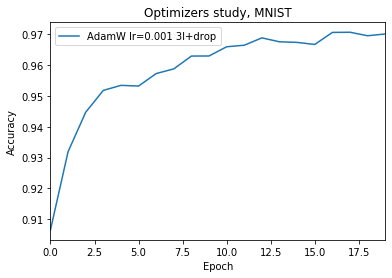

In [0]:
df['AdamW lr=0.001 3l+drop'] = res
ax = df.plot(title='Optimizers study, MNIST')#,xticks=[0,1,2,3,4,5,6,7,8,9]);
ax.set_xlabel("Epoch");
ax.set_ylabel("Accuracy");

In [0]:
df.to_csv('optimizers-res2.csv')

## Model defined as a Sequence of Layers

In [0]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(100,10),
    nn.LogSoftmax(dim=1)
    )

In [0]:
model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): LogSoftmax()
)

# Inference

In [0]:
#plt.bar(range(0,10),l2res[4].detach(),tick_label=[0,1,2,3,4,5,6,7,8,9]);

In [0]:
data.show_batch(4,ds_type=DatasetType.Test,figsize=(6,6))

In [0]:
xb,_ = next(iter(data.test_dl))
#x = data.test_ds[10][0].px.reshape(-1)

In [0]:
xb = xb.reshape(-1,784)

In [0]:
preds = model(xb).argmax(dim=1)

In [0]:
for i in range(len(data.test_dl)):
    print(i)

In [0]:
data.test_ds.x[0]

In [0]:
plt.plot(data.test_ds.x[0])#,preds[0]

# Neural net using torch.nn

In [0]:
def simple_cnn(actns:Collection[int], kernel_szs:Collection[int]=None,
               strides:Collection[int]=None) -> nn.Sequential:
    "CNN with `conv2d_relu` layers defined by `actns`, `kernel_szs` and `strides`"
    nl = len(actns)-1
    kernel_szs = ifnone(kernel_szs, [3]*nl)
    strides    = ifnone(strides   , [2]*nl)
    layers = [conv_layer(actns[i], actns[i+1], kernel_szs[i], stride=strides[i])
        for i in range(len(strides))]
    layers.append(nn.Sequential(AdaptiveConcatPool2d(1), Flatten()))
    return nn.Sequential(*layers)

In [11]:
model = simple_cnn((3,16,16,5))
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 5, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten()
  )
)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy,
                    callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.001, patience=3),
                                          ShowGraph])

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


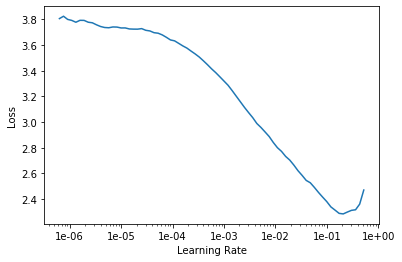

In [13]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.240215,0.152117,0.952750,01:32
1,0.133004,0.088209,0.974083,01:32
2,0.116195,0.058805,0.983917,01:33
3,0.116799,0.073823,0.977083,01:33
4,0.118568,0.105394,0.967833,01:33
5,0.118191,0.071956,0.978250,01:33
6,0.099247,0.045549,0.987000,01:33
7,0.086165,0.066388,0.986583,01:33
8,0.091012,0.093308,0.975083,01:33
9,0.076370,0.129007,0.985333,01:33


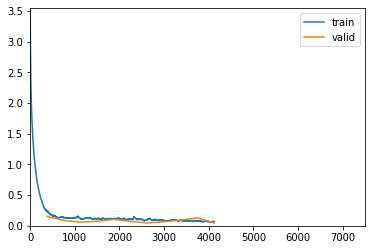

Epoch 3: reducing lr to 0.0030399999999999997
Epoch 4: reducing lr to 0.0037427687752661226
Epoch 5: reducing lr to 0.004
Epoch 7: reducing lr to 0.0038019385280538952
Epoch 8: reducing lr to 0.0035636647102842
Epoch 9: reducing lr to 0.0032469826157990526
Epoch 10: early stopping
Epoch 10: reducing lr to 0.0028677720071652035


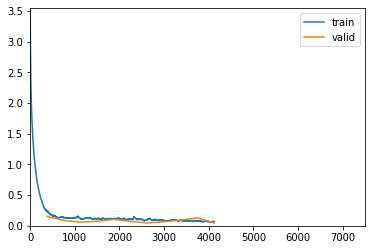

In [16]:
learn.fit_one_cycle(20,max_lr=2e-2, 
  callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy'),
             ReduceLROnPlateauCallback(learn, monitor='valid_loss')])

In [49]:
!ls -l ~/.fastai/data/mnist_sample/models

total 0


In [0]:
!rm ~/.fastai/data/mnist_sample/models/*.pth

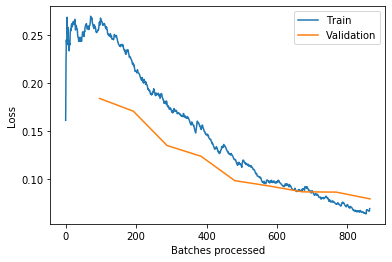

In [46]:
learn.recorder.plot_losses()